In [1]:
data_location = 'sqlite:///../../data/data.db'


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

import pickle

In [3]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [4]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring=None
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [5]:
ohlc = pd.read_sql('SELECT * FROM ohlc', data_location)


In [6]:
tokens = ohlc.token.unique()


In [7]:
def df_merge(left, right):
    return pd.merge(left, right, on='ts', how='inner')

X = reduce(df_merge, [
    (lambda df: 
    (
        df
        .assign(
            vol=vol_ohlc(df).fillna(0),
            ret=df.close.pct_change()
        )[['ts', 'vol', 'ret']]
        .rename(columns={
            col: f'{col}_{token}' for col in ['ts', 'vol', 'ret'] if col != 'ts'
        })
    ))(ohlc[ohlc.token == token])
    for token in tokens
]).set_index('ts')

In [8]:
y = X.ret_SOL.shift(-1)[:-1]
X = X[:-1]


In [9]:
X

,vol_BTC,ret_BTC,vol_ETH,ret_ETH,vol_USDT,ret_USDT,vol_SOL,ret_SOL,vol_ADA,ret_ADA,...,vol_AVAX,ret_AVAX,vol_ATOM,ret_ATOM,vol_CRV,ret_CRV,vol_AAVE,ret_AAVE,vol_COMP,ret_COMP
ts,,,,,,,,,,,,,,,,,,,,,
2021-11-01 00:00:00,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN
2021-11-01 01:00:00,0.000000,0.004357,0.000000,0.006874,0.000000,0.0000,0.000000,0.027359,0.000000,0.003203,...,0.000000,-0.006346,0.000000,0.008193,0.000000,0.000725,0.000000,0.008043,0.000000,-0.002281
2021-11-01 02:00:00,0.000000,-0.004508,0.000000,-0.005322,0.000000,-0.0002,0.000000,-0.009879,0.000000,-0.008667,...,0.000000,-0.006231,0.000000,-0.025419,0.000000,-0.031791,0.000000,-0.009171,0.000000,-0.006020
2021-11-01 03:00:00,0.000000,-0.012132,0.000000,-0.013126,0.000000,0.0001,0.000000,-0.021692,0.000000,-0.007618,...,0.000000,-0.005329,0.000000,-0.013943,0.000000,-0.010431,0.000000,-0.013301,0.000000,-0.022273
2021-11-01 04:00:00,0.000000,-0.010186,0.000000,-0.010679,0.000000,0.0000,0.000000,-0.003039,0.000000,-0.006903,...,0.000000,-0.008667,0.000000,-0.020046,0.000000,0.004514,0.000000,-0.016452,0.000000,-0.024002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-14 19:00:00,0.136406,0.000402,0.159860,-0.002922,0.002354,0.0000,0.220576,-0.001624,0.223436,0.000326,...,0.236402,-0.014223,0.253997,-0.007009,0.256996,-0.006061,0.206319,-0.005855,0.286230,-0.011428
2021-12-14 20:00:00,0.136358,0.004810,0.158369,0.005961,0.002463,0.0001,0.216740,0.002798,0.225286,0.014437,...,0.239258,0.008227,0.254118,-0.000471,0.255464,0.003049,0.207758,0.009387,0.284268,0.006813
2021-12-14 21:00:00,0.142237,0.019797,0.170096,0.016737,0.002652,0.0000,0.218492,0.025892,0.224116,0.012141,...,0.241603,0.019207,0.254350,0.019303,0.263456,0.021277,0.222014,0.022490,0.281497,0.017473


In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet


from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import learning_curve

In [11]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]


In [13]:
def evaluate_model(model, X, y, test_size=0.2):
    cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
    scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    
    return np.mean(cross_validate(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)['test_score'])

PCA replaced by Feature Selection Through Elastic Net

In [48]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('model', ElasticNet())
])

evaluate_model(pipeline, X, y)

-0.008570816681474391

In [85]:
from sklearn.model_selection import GridSearchCV

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(pipeline, {
    'model__alpha': [0.2, 0.5,  1.],
    'model__l1_ratio':[0.2,0.5,1.0]
}, scoring=scorer, refit=True, cv=cv, n_jobs=-1)
search.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=211, test_size=1),
             estimator=Pipeline(steps=[('impute',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
                                       ('model', ElasticNet())]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.2, 0.5, 1.0],
                         'model__l1_ratio': [0.2, 0.5, 1.0]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False))

In [86]:
best_model = search.best_estimator_
new_score=evaluate_model(best_model, X, y)
print(new_score)

-0.008570816681474391


In [87]:
score_to_beat=-0.008575141851714435

In [88]:
new_score>score_to_beat

True

Best Parameters:

In [89]:
search.best_params_

{'model__alpha': 0.2, 'model__l1_ratio': 0.2}

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

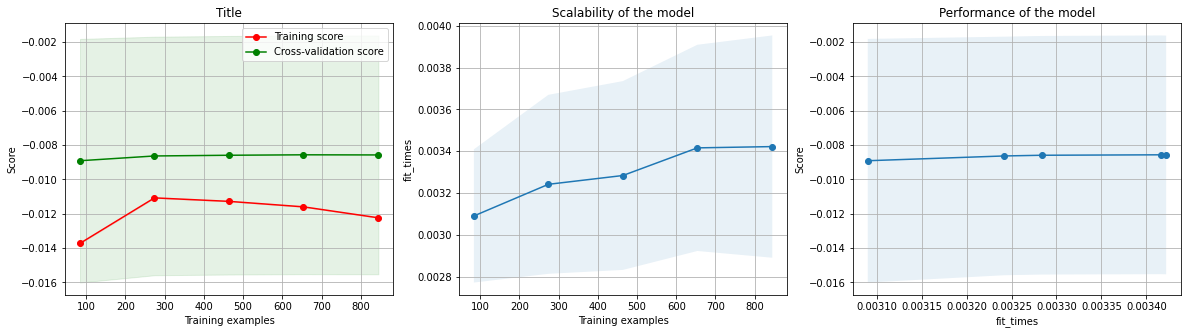

In [90]:
plot_learning_curve(search.best_estimator_,'Title',X,y,cv=cv,n_jobs=4,scoring=scorer)